In [1]:
%matplotlib widget


from pacti import write_contracts_to_file
from pacti.contracts import PolyhedralIoContract
from pacti.iocontract import Var
from contract_utils import *
from plot_utils import plot_guarantees_with_bounds_hover

## Power viewpoint modeling

### CHARGING Task

Objective: charge the spacecraft battery

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the battery charges proportionally to a generation rate.

Contract charging1_power:

InVars: [soc2_entry, duration_charging2]
OutVars:[soc2_exit]
A: [
  -duration_charging2 <= -0
  -soc2_entry <= -0
  soc2_entry <= 100
  5 duration_charging2 + soc2_entry <= 100
]
G: [
  4 duration_charging2 + soc2_entry - soc2_exit <= 0
  -5 duration_charging2 - soc2_entry + soc2_exit <= 0
]


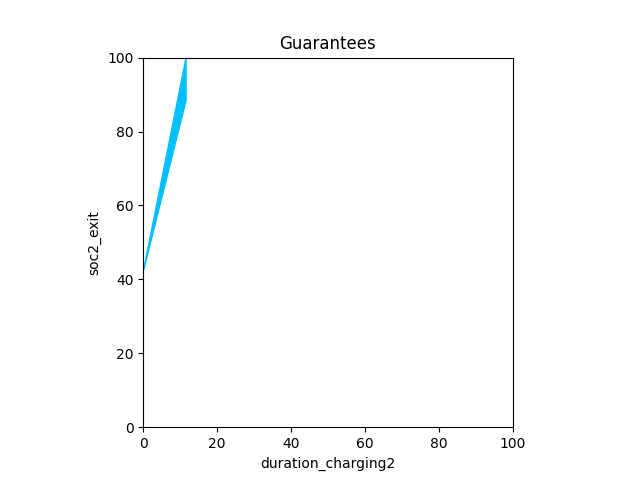

In [2]:
# Parameters:
# - s: index of the timeline variables
# - generation: (min, max) rate of battery charge during the task instance
def CHRG_power(s: int, generation: Tuple[float, float]) -> PolyhedralIoContract:
  spec = PolyhedralIoContract.from_strings(
    input_vars = [
      f"soc{s}_entry",          # initial battery SOC
      f"duration_charging{s}",  # variable task duration
    ],
    output_vars = [
      f"soc{s}_exit",           # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"0 <= duration_charging{s}",
      # Lower and upper bound on entry soc
      f"0 <= soc{s}_entry <= 100.0",
      # The increase under the maximum generation rate should not overcharge the battery.
      f"soc{s}_entry + {generation[1]}*duration_charging{s} <= 100",
    ],
    guarantees = [
      # duration*generation(min) <= soc{exit} - soc{entry} <= duration*generation(max)
      f"{generation[0]}*duration_charging{s} <= soc{s}_exit - soc{s}_entry <= {generation[1]}*duration_charging{s}",

      # Battery cannot exceed maximum SOC
      f"soc{s}_exit <= 100.0",
      
      # Battery should not completely discharge
      f"0 <= soc{s}_exit",
    ])
  return spec

charging1_power = CHRG_power(s=2, generation=(4.0, 5.0))
print(f"Contract charging1_power:\n\n{charging1_power}")

_ = plot_guarantees_with_bounds_hover(contract=charging1_power,
                x_var=Var("duration_charging2"),
                y_var=Var("soc2_exit"),
                var_values={
                  Var("soc2_entry"):42,
                },
                x_lims=(0,100),
                y_lims=(0,100))


### Power-consuming Tasks (DSN, SBO, TCM)

In [3]:
# Parameters:
# - s: start index of the timeline variables
# - consumption: (min, max) rate of battery discharge during the task instance
def power_consumer(s: int, task: str, consumption: Tuple[float, float]) -> PolyhedralIoContract:
  spec = PolyhedralIoContract.from_strings(
    input_vars = [
      f"soc{s}_entry",          # initial battery SOC
      f"duration_{task}{s}",    # variable task duration
    ],
    output_vars = [
      f"soc{s}_exit",           # final battery SOC
    ],
    assumptions = [
        # Task has a positive scheduled duration
        f"0 <= duration_{task}{s}",
        # Upper bound on entry soc
        f"soc{s}_entry <= 100.0",
        # Lower bound on entry soc
        f"0 <= soc{s}_entry",
        # Battery has enough energy for worst-case consumption throughout the task instance
        f"soc{s}_entry >= {consumption[1]}*duration_{task}{s}",
    ],
    guarantees=[
        # duration*consumption(min) <= soc{entry} - soc{exit} <= duration*consumption(max)
        f"{consumption[0]}*duration_{task}{s} <= soc{s}_entry - soc{s}_exit <= {consumption[1]}*duration_{task}{s}",
        # Battery cannot exceed maximum SOC
        f"soc{s}_exit <= 100",
        # Battery should not completely discharge
        f"0 <= soc{s}_exit",
    ])
  return spec

### DSN Task

Objective: downlink science data to Earth.

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the battery discharges proportionally to a consumption rate.


Contract dsn1_power:

InVars: [soc1_entry, duration_dsn1]
OutVars:[soc1_exit]
A: [
  -duration_dsn1 <= -0
  soc1_entry <= 100
  -soc1_entry <= -0
  2.2 duration_dsn1 - soc1_entry <= 0
]
G: [
  2 duration_dsn1 - soc1_entry + soc1_exit <= 0
  -2.2 duration_dsn1 + soc1_entry - soc1_exit <= 0
]


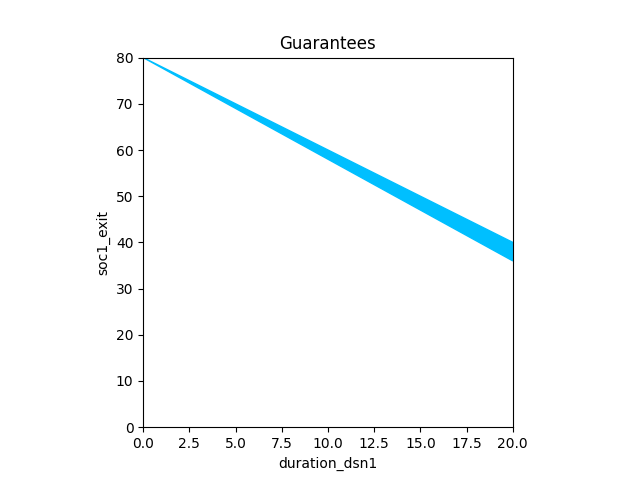

In [4]:
dsn1_power = power_consumer(s=1, task="dsn", consumption=(2.0, 2.2))
print(f"Contract dsn1_power:\n\n{dsn1_power}")

_ = plot_guarantees_with_bounds_hover(contract=dsn1_power,
                x_var=Var("duration_dsn1"),
                y_var=Var("soc1_exit"),
                var_values={
                  Var("soc1_entry"):80,
                },
                x_lims=(0,20),
                y_lims=(0,80))


### SBO Task (Small body observations)

Objective: Acquire small body observations (science data & navigation)

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the battery discharges proportionally to a consumption rate.

Contract sbo1_power:

InVars: [soc3_entry, duration_sbo3]
OutVars:[soc3_exit]
A: [
  -duration_sbo3 <= -0
  soc3_entry <= 100
  -soc3_entry <= -0
  0.2 duration_sbo3 - soc3_entry <= 0
]
G: [
  0.1 duration_sbo3 - soc3_entry + soc3_exit <= 0
  -0.2 duration_sbo3 + soc3_entry - soc3_exit <= 0
]


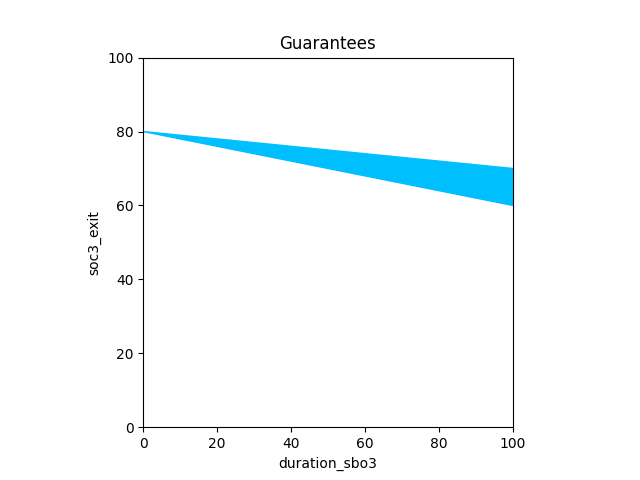

In [5]:
sbo1_power = power_consumer(s=3, task="sbo", consumption=(0.1, 0.2))
print(f"Contract sbo1_power:\n\n{sbo1_power}")

_ = plot_guarantees_with_bounds_hover(contract=sbo1_power,
                x_var=Var("duration_sbo3"),
                y_var=Var("soc3_exit"),
                var_values={
                  Var("soc3_entry"):80,
                },
                x_lims=(0,100),
                y_lims=(0,100))

### TCM Task (Perform a Trajectory Correction Maneuver)

Objective: Perform a delta-V maneuver to bring the spacecraft trajectory closer to that of the small body.

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- Power: the thrusters must be heated before firing them, thereby discharging the battery proportionally to a consumption rate.

Since heating the thruster must happen just before firing them, this task is modeled as the composition of two subtasks: Heating and DeltaV.

#### TCM Heating SubTask


Contract tcm1_heating_power:

InVars: [soc4_entry, duration_tcm_heating4]
OutVars:[soc4_exit]
A: [
  -duration_tcm_heating4 <= -0
  soc4_entry <= 100
  -soc4_entry <= -0
  0.8 duration_tcm_heating4 - soc4_entry <= 0
]
G: [
  0.7 duration_tcm_heating4 - soc4_entry + soc4_exit <= 0
  -0.8 duration_tcm_heating4 + soc4_entry - soc4_exit <= 0
]


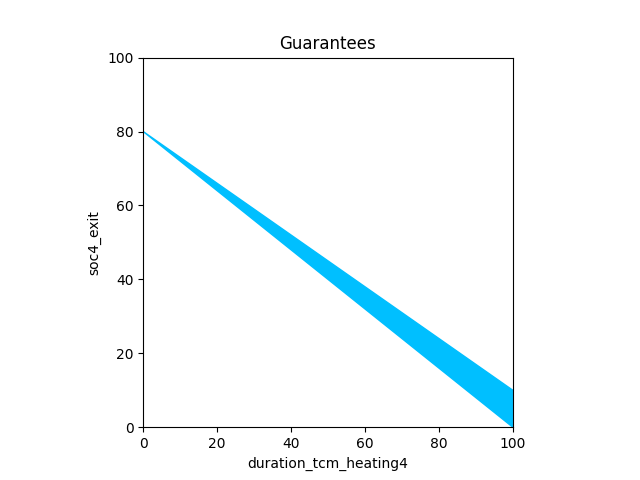

In [6]:
tcm1_heating_power = power_consumer(s=4, task="tcm_heating", consumption=(0.7, 0.8))
print(f"Contract tcm1_heating_power:\n\n{tcm1_heating_power}")

_ = plot_guarantees_with_bounds_hover(contract=tcm1_heating_power,
                x_var=Var("duration_tcm_heating4"),
                y_var=Var("soc4_exit"),
                var_values={
                  Var("soc4_entry"):80,
                },
                x_lims=(0,100),
                y_lims=(0,100))

#### TCM DeltaV SubTask


Contract tcm1_deltav_power:

InVars: [soc5_entry, duration_tcm_deltav5]
OutVars:[soc5_exit]
A: [
  -duration_tcm_deltav5 <= -0
  soc5_entry <= 100
  -soc5_entry <= -0
  0.3 duration_tcm_deltav5 - soc5_entry <= 0
]
G: [
  0.2 duration_tcm_deltav5 - soc5_entry + soc5_exit <= 0
  -0.3 duration_tcm_deltav5 + soc5_entry - soc5_exit <= 0
]


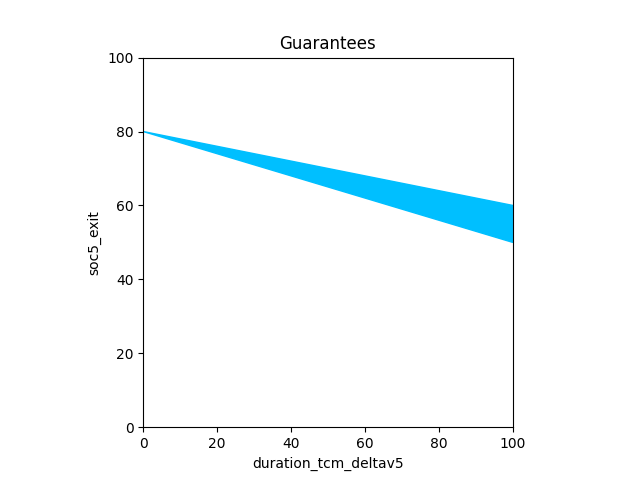

In [7]:
tcm1_deltav_power = power_consumer(s=5, task="tcm_deltav", consumption=(0.2, 0.3))
print(f"Contract tcm1_deltav_power:\n\n{tcm1_deltav_power}")

_ = plot_guarantees_with_bounds_hover(contract=tcm1_deltav_power,
                x_var=Var("duration_tcm_deltav5"),
                y_var=Var("soc5_exit"),
                var_values={
                  Var("soc5_entry"):80,
                },
                x_lims=(0,100),
                y_lims=(0,100))

#### Composing TCM SubTasks

Algebraic composition allows us to capture the requirement that a TCM Heating subtask must always precede a TCM DeltaV subtask by composing them.

In [8]:
tcm1_power=scenario_sequence(c1=tcm1_heating_power, c2=tcm1_deltav_power, variables=["soc"], c1index=4)
print(f"========= tcm1_power\n{tcm1_power}")
print('\n'.join(bounds(tcm1_power)))

========= tcm1_power
InVars: [soc4_entry, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[soc5_exit, output_soc4]
A: [
  -duration_tcm_deltav5 <= 0
  0.3 duration_tcm_deltav5 + 0.8 duration_tcm_heating4 - soc4_entry <= 0
  -duration_tcm_heating4 <= 0
  soc4_entry <= 100
]
G: [
  0.7 duration_tcm_heating4 + output_soc4 - soc4_entry <= 0
  -0.8 duration_tcm_heating4 - output_soc4 + soc4_entry <= 0
  0.2 duration_tcm_deltav5 - output_soc4 + soc5_exit <= 0
  -0.3 duration_tcm_deltav5 + output_soc4 - soc5_exit <= 0
]
 input duration_tcm_deltav5 in [0.00,333.33]
 input duration_tcm_heating4 in [0.00,125.00]
 input soc4_entry in [0.00,100.00]
output output_soc4 in [0.00,100.00]
output soc5_exit in [-0.00,100.00]


### Power Schedule Analysis

Let's consider a simple 4-step schedule of the following sequence of task instances, which we compose:
- DSN
- CHARGING
- SBO
- TCM

In [9]:
steps12=scenario_sequence(c1=dsn1_power, c2=charging1_power, variables=["soc"], c1index=1)
print(f"---- L2R Steps 1,2\n{steps12}")
print('\n'.join(bounds(steps12)))

---- L2R Steps 1,2
InVars: [soc1_entry, duration_dsn1, duration_charging2]
OutVars:[soc2_exit, output_soc1]
A: [
  -duration_charging2 <= 0
  5 duration_charging2 - 2 duration_dsn1 + soc1_entry <= 100
  -duration_dsn1 <= 0
  soc1_entry <= 100
  2.2 duration_dsn1 - soc1_entry <= 0
]
G: [
  2 duration_dsn1 + output_soc1 - soc1_entry <= 0
  -2.2 duration_dsn1 - output_soc1 + soc1_entry <= 0
  4 duration_charging2 + output_soc1 - soc2_exit <= 0
  -5 duration_charging2 - output_soc1 + soc2_exit <= 0
]
 input duration_charging2 in [0.00,20.00]
 input duration_dsn1 in [0.00,45.45]
 input soc1_entry in [0.00,100.00]
output output_soc1 in [0.00,100.00]
output soc2_exit in [0.00,100.00]


In [10]:
steps23=scenario_sequence(c1=charging1_power, c2=sbo1_power, variables=["soc"], c1index=2)
print(f"---- L2R Steps 2,3\n{steps23}")
print('\n'.join(bounds(steps23)))

---- L2R Steps 2,3
InVars: [soc2_entry, duration_charging2, duration_sbo3]
OutVars:[soc3_exit, output_soc2]
A: [
  -duration_sbo3 <= 0
  -4 duration_charging2 + 0.2 duration_sbo3 - soc2_entry <= 0
  -duration_charging2 <= 0
  -soc2_entry <= 0
  5 duration_charging2 + soc2_entry <= 100
]
G: [
  4 duration_charging2 - output_soc2 + soc2_entry <= 0
  -5 duration_charging2 + output_soc2 - soc2_entry <= 0
  0.1 duration_sbo3 - output_soc2 + soc3_exit <= 0
  -0.2 duration_sbo3 + output_soc2 - soc3_exit <= 0
]
 input duration_charging2 in [0.00,20.00]
 input duration_sbo3 in [0.00,500.00]
 input soc2_entry in [0.00,100.00]
output output_soc2 in [0.00,100.00]
output soc3_exit in [0.00,100.00]


In [11]:
steps1_23=scenario_sequence(c1=dsn1_power, c2=steps23, variables=["soc"], c1index=1)
print(f"---- L2R Steps 1 and 2,3\n{steps1_23}")
print('\n'.join(bounds(steps1_23)))

---- L2R Steps 1 and 2,3
InVars: [soc1_entry, duration_dsn1, duration_charging2, duration_sbo3]
OutVars:[soc3_exit, output_soc2, output_soc1]
A: [
  -duration_sbo3 <= 0
  -4 duration_charging2 + 2.2 duration_dsn1 + 0.2 duration_sbo3 - soc1_entry <= 0
  -duration_charging2 <= 0
  5 duration_charging2 - 2 duration_dsn1 + soc1_entry <= 100
  -duration_dsn1 <= 0
  soc1_entry <= 100
  2.2 duration_dsn1 - soc1_entry <= 0
]
G: [
  2 duration_dsn1 + output_soc1 - soc1_entry <= 0
  -2.2 duration_dsn1 - output_soc1 + soc1_entry <= 0
  4 duration_charging2 + output_soc1 - output_soc2 <= 0
  -5 duration_charging2 - output_soc1 + output_soc2 <= 0
  0.1 duration_sbo3 - output_soc2 + soc3_exit <= 0
  -0.2 duration_sbo3 + output_soc2 - soc3_exit <= 0
]
 input duration_charging2 in [0.00,20.00]
 input duration_dsn1 in [0.00,45.45]
 input duration_sbo3 in [0.00,500.00]
 input soc1_entry in [0.00,100.00]
output output_soc1 in [0.00,100.00]
output output_soc2 in [0.00,100.00]
output soc3_exit in [0.00,100

In [12]:
steps123=scenario_sequence(c1=steps12, c2=sbo1_power, variables=["soc"], c1index=2)
print(f"---- L2R Steps 1,2,3\n{steps123}")
print('\n'.join(bounds(steps123)))

---- L2R Steps 1,2,3
InVars: [soc1_entry, duration_dsn1, duration_charging2, duration_sbo3]
OutVars:[output_soc1, soc3_exit, output_soc2]
A: [
  -duration_sbo3 <= 0
  -4 duration_charging2 + 2 duration_dsn1 + 0.2 duration_sbo3 - soc1_entry <= 0
  -duration_charging2 <= 0
  5 duration_charging2 - 2 duration_dsn1 + soc1_entry <= 100
  -duration_dsn1 <= 0
  soc1_entry <= 100
  2.2 duration_dsn1 - soc1_entry <= 0
]
G: [
  2 duration_dsn1 + output_soc1 - soc1_entry <= 0
  -2.2 duration_dsn1 - output_soc1 + soc1_entry <= 0
  4 duration_charging2 + output_soc1 - output_soc2 <= 0
  -5 duration_charging2 - output_soc1 + output_soc2 <= 0
  0.1 duration_sbo3 - output_soc2 + soc3_exit <= 0
  -0.2 duration_sbo3 + output_soc2 - soc3_exit <= 0
]
 input duration_charging2 in [0.00,20.00]
 input duration_dsn1 in [0.00,45.45]
 input duration_sbo3 in [0.00,500.00]
 input soc1_entry in [0.00,100.00]
output output_soc1 in [0.00,100.00]
output output_soc2 in [0.00,100.00]
output soc3_exit in [-9.09,100.00]


In [13]:
back34=scenario_sequence(c1=sbo1_power, c2=tcm1_power, variables=["soc"], c1index=3)
print(f"---- R2L Steps 3,4\n{back34}")
print('\n'.join(bounds(back34)))

---- R2L Steps 3,4
InVars: [soc3_entry, duration_sbo3, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[soc5_exit, output_soc4, output_soc3]
A: [
  -duration_tcm_deltav5 <= 0
  0.2 duration_sbo3 + 0.3 duration_tcm_deltav5 + 0.8 duration_tcm_heating4 - soc3_entry <= 0
  -duration_tcm_heating4 <= 0
  -duration_sbo3 <= 0
  soc3_entry <= 100
]
G: [
  0.1 duration_sbo3 + output_soc3 - soc3_entry <= 0
  -0.2 duration_sbo3 - output_soc3 + soc3_entry <= 0
  0.7 duration_tcm_heating4 - output_soc3 + output_soc4 <= 0
  -0.8 duration_tcm_heating4 + output_soc3 - output_soc4 <= 0
  0.2 duration_tcm_deltav5 - output_soc4 + soc5_exit <= 0
  -0.3 duration_tcm_deltav5 + output_soc4 - soc5_exit <= 0
]
 input duration_sbo3 in [0.00,500.00]
 input duration_tcm_deltav5 in [0.00,333.33]
 input duration_tcm_heating4 in [0.00,125.00]
 input soc3_entry in [0.00,100.00]
output output_soc3 in [0.00,100.00]
output output_soc4 in [0.00,100.00]
output soc5_exit in [-0.00,100.00]


In [14]:
back234=scenario_sequence(c1=charging1_power, c2=back34, variables=["soc"], c1index=2)
print(f"---- R2L Steps 2,3,4\n{back234}")
print('\n'.join(bounds(back234)))

---- R2L Steps 2,3,4
InVars: [soc2_entry, duration_charging2, duration_sbo3, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[soc5_exit, output_soc4, output_soc3, output_soc2]
A: [
  -duration_tcm_deltav5 <= 0
  -4 duration_charging2 + 0.2 duration_sbo3 + 0.3 duration_tcm_deltav5 + 0.8 duration_tcm_heating4 - soc2_entry <= 0
  -duration_tcm_heating4 <= 0
  -duration_sbo3 <= 0
  -duration_charging2 <= 0
  -soc2_entry <= 0
  5 duration_charging2 + soc2_entry <= 100
]
G: [
  4 duration_charging2 - output_soc2 + soc2_entry <= 0
  -5 duration_charging2 + output_soc2 - soc2_entry <= 0
  0.1 duration_sbo3 - output_soc2 + output_soc3 <= 0
  -0.2 duration_sbo3 + output_soc2 - output_soc3 <= 0
  0.7 duration_tcm_heating4 - output_soc3 + output_soc4 <= 0
  -0.8 duration_tcm_heating4 + output_soc3 - output_soc4 <= 0
  0.2 duration_tcm_deltav5 - output_soc4 + soc5_exit <= 0
  -0.3 duration_tcm_deltav5 + output_soc4 - soc5_exit <= 0
]
 input duration_charging2 in [0.00,20.00]
 input duration_sb

In [15]:
back1234=scenario_sequence(c1=dsn1_power, c2=back234, variables=["soc"], c1index=1).rename_variables([("soc5_exit", "output_soc5")])
print(f"---- Steps 1,2,3,4 R2L\n{back1234}")
print('\n'.join(bounds(back1234)))

---- Steps 1,2,3,4 R2L
InVars: [soc1_entry, duration_dsn1, duration_charging2, duration_sbo3, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[output_soc4, output_soc3, output_soc2, output_soc1, output_soc5]
A: [
  -duration_tcm_deltav5 <= 0
  -4 duration_charging2 + 2.2 duration_dsn1 + 0.2 duration_sbo3 + 0.3 duration_tcm_deltav5 + 0.8 duration_tcm_heating4 - soc1_entry <= 0
  -duration_tcm_heating4 <= 0
  -duration_sbo3 <= 0
  -duration_charging2 <= 0
  5 duration_charging2 - 2 duration_dsn1 + soc1_entry <= 100
  -duration_dsn1 <= 0
  soc1_entry <= 100
  2.2 duration_dsn1 - soc1_entry <= 0
]
G: [
  2 duration_dsn1 + output_soc1 - soc1_entry <= 0
  -2.2 duration_dsn1 - output_soc1 + soc1_entry <= 0
  4 duration_charging2 + output_soc1 - output_soc2 <= 0
  -5 duration_charging2 - output_soc1 + output_soc2 <= 0
  0.1 duration_sbo3 - output_soc2 + output_soc3 <= 0
  -0.2 duration_sbo3 + output_soc2 - output_soc3 <= 0
  0.7 duration_tcm_heating4 - output_soc3 + output_soc4 <= 0
  -0.

In [16]:
steps1234=scenario_sequence(c1=steps123, c2=tcm1_power, variables=["soc"], c1index=3).rename_variables([("soc5_exit", "output_soc5")])
print(f"---- Steps 1,2,3,4 L2R\n{steps1234}")
print('\n'.join(bounds(steps1234)))

---- Steps 1,2,3,4 L2R
InVars: [soc1_entry, duration_dsn1, duration_charging2, duration_sbo3, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[output_soc1, output_soc2, output_soc4, output_soc3, output_soc5]
A: [
  -duration_tcm_deltav5 <= 0
  -5 duration_charging2 + 2 duration_dsn1 + 0.2 duration_sbo3 + 0.3 duration_tcm_deltav5 + 0.8 duration_tcm_heating4 - soc1_entry <= 0
  -duration_tcm_heating4 <= 0
  -duration_sbo3 <= 0
  -4 duration_charging2 + 2 duration_dsn1 + 0.2 duration_sbo3 - soc1_entry <= 0
  -duration_charging2 <= 0
  5 duration_charging2 - 2 duration_dsn1 + soc1_entry <= 100
  -duration_dsn1 <= 0
  soc1_entry <= 100
  2.2 duration_dsn1 - soc1_entry <= 0
]
G: [
  2 duration_dsn1 + output_soc1 - soc1_entry <= 0
  -2.2 duration_dsn1 - output_soc1 + soc1_entry <= 0
  4 duration_charging2 + output_soc1 - output_soc2 <= 0
  -5 duration_charging2 - output_soc1 + output_soc2 <= 0
  0.1 duration_sbo3 - output_soc2 + output_soc3 <= 0
  -0.2 duration_sbo3 + output_soc2 - outpu

In [17]:
print(f"L2R refines R2L? : {steps1234.refines(back1234)}")
print(f"R2L refines L2R? : {back1234.refines(steps1234)}")

L2R refines R2L? : True
R2L refines L2R? : False


#### Power Schedule constraints

In [18]:
write_contracts_to_file(
    contracts=[steps1234, back1234], 
    names=["scenario_power_left_to_right_composition", "scenario_power_right_to_left_composition"], 
    file_name="json/scenario_power.json")